# Exercise 1

### Cleaned Data importing

In [1]:
# basic imports
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

# reading the data
data = pd.read_csv("data/clean_data.csv", sep=',')
data = data.replace([np.inf, -np.inf], np.nan).dropna()
print("data shape = ")
print(data.shape)
# Display the first 10 rows of the dataset. Only 13 columns for space reasons
print("Fist 13 columns :")
data.ix[:10,:13]

data shape = 
(1419, 19)
Fist 13 columns :


,Unnamed: 0,playerShort,redCards,leagueCountry,yellowCards,victories,yellowReds,black,weight,meanExp,goals,birthday,meanIAT
0,0,0,0,0,19,247,0,0,71.0,0.494575,9,08.11.1979,0.346459
1,1,1,1,2,42,141,0,0,73.0,0.449220,62,04.09.1986,0.348818
2,2,2,0,0,11,200,0,0,63.0,0.491482,31,16.04.1987,0.345893
3,3,3,1,0,31,150,0,0,76.0,0.514693,39,26.12.1990,0.346821
4,4,4,2,1,8,41,4,0,73.0,0.335587,1,17.03.1990,0.331600
5,5,5,0,1,11,41,1,1,74.0,0.296562,3,17.01.1988,0.320079
6,6,6,0,1,0,8,0,1,80.0,0.400818,0,30.03.1992,0.341625
7,7,7,0,1,0,0,0,1,83.0,0.417225,0,19.08.1990,0.355406
8,8,8,2,1,21,34,0,1,68.0,0.429630,3,20.03.1990,0.348178
9,9,9,1,2,3,17,0,1,70.0,0.361068,0,02.07.1994,0.342072


In [2]:
# Display the other columns too
print("the other columns : ")
data.ix[:10,13:19]

the other columns : 


,games,defeats,ties,club,position,height
0,654,228,179,34,Center Back,182.0
1,336,122,73,91,Attacking Midfielder,183.0
2,412,115,97,83,Right Midfielder,165.0
3,260,68,42,6,Center Midfielder,178.0
4,124,43,40,51,Center Back,180.0
5,97,33,23,36,Right Midfielder,180.0
6,24,8,8,80,Goalkeeper,189.0
7,3,2,1,36,Goalkeeper,188.0
8,121,62,25,78,Defensive Midfielder,180.0
9,50,25,8,77,Left Fullback,179.0


### Define features and labels

In [3]:
# labels
data_y = data['black']
data_y.head()

0    0
1    0
2    0
3    0
4    0
Name: black, dtype: int64

In [4]:
# features
data_x = data.drop(data.columns[[7,11,17]], axis=1).astype(float)
data_x.dtypes

Unnamed: 0       float64
playerShort      float64
redCards         float64
leagueCountry    float64
yellowCards      float64
victories        float64
yellowReds       float64
weight           float64
meanExp          float64
goals            float64
meanIAT          float64
games            float64
defeats          float64
ties             float64
club             float64
height           float64
dtype: object

In [5]:
data_x.ix[:10,:13]

,Unnamed: 0,playerShort,redCards,leagueCountry,yellowCards,victories,yellowReds,weight,meanExp,goals,meanIAT,games,defeats
0,0.0,0.0,0.0,0.0,19.0,247.0,0.0,71.0,0.494575,9.0,0.346459,654.0,228.0
1,1.0,1.0,1.0,2.0,42.0,141.0,0.0,73.0,0.449220,62.0,0.348818,336.0,122.0
2,2.0,2.0,0.0,0.0,11.0,200.0,0.0,63.0,0.491482,31.0,0.345893,412.0,115.0
3,3.0,3.0,1.0,0.0,31.0,150.0,0.0,76.0,0.514693,39.0,0.346821,260.0,68.0
4,4.0,4.0,2.0,1.0,8.0,41.0,4.0,73.0,0.335587,1.0,0.331600,124.0,43.0
5,5.0,5.0,0.0,1.0,11.0,41.0,1.0,74.0,0.296562,3.0,0.320079,97.0,33.0
6,6.0,6.0,0.0,1.0,0.0,8.0,0.0,80.0,0.400818,0.0,0.341625,24.0,8.0
7,7.0,7.0,0.0,1.0,0.0,0.0,0.0,83.0,0.417225,0.0,0.355406,3.0,2.0
8,8.0,8.0,2.0,1.0,21.0,34.0,0.0,68.0,0.429630,3.0,0.348178,121.0,62.0
9,9.0,9.0,1.0,2.0,3.0,17.0,0.0,70.0,0.361068,0.0,0.342072,50.0,25.0


In [6]:
data_x.ix[:10,13:16]

,ties,club,height
0,179.0,34.0,182.0
1,73.0,91.0,183.0
2,97.0,83.0,165.0
3,42.0,6.0,178.0
4,40.0,51.0,180.0
5,23.0,36.0,180.0
6,8.0,80.0,189.0
7,1.0,36.0,188.0
8,25.0,78.0,180.0
9,8.0,77.0,179.0


### Split data into train and test data

In [7]:
data_y = np.asarray(data_y)
data_x = data_x.as_matrix()

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=4)

In [9]:
print(y_train.shape)
print(y_test.shape)

(950,)
(469,)


### Random Forest Classifier

Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color.

In [10]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)

make predictions using the model

In [11]:
y_pred = clf.predict(X_test)

prediction score 

In [12]:
print(metrics.accuracy_score(y_test, y_pred))
clf.score(X_test, y_test)

0.844349680171


0.84434968017057566

ratio = 0.1, train data score = 0.9859044635865309, test data score = 0.8591549295774648
ratio = 0.2, train data score = 0.9797356828193833, test data score = 0.852112676056338
ratio = 0.30000000000000004, train data score = 0.9778449144008057, test data score = 0.8568075117370892
ratio = 0.4, train data score = 0.982373678025852, test data score = 0.8450704225352113
ratio = 0.5, train data score = 0.9830747531734838, test data score = 0.8422535211267606
ratio = 0.6, train data score = 0.9876543209876543, test data score = 0.8427230046948356
ratio = 0.7000000000000001, train data score = 0.9764705882352941, test data score = 0.8450704225352113
ratio = 0.8, train data score = 0.9681978798586572, test data score = 0.8380281690140845
ratio = 0.9, train data score = 0.9787234042553191, test data score = 0.823943661971831


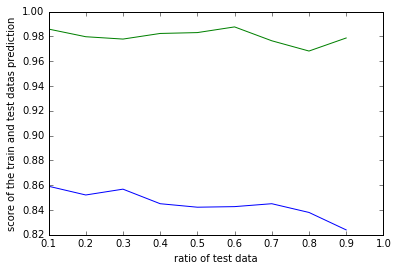

In [14]:
# different ratio values
ratio = np.arange(0.1,1.,0.1)
tr_score = []
te_score = []

for i in  np.arange(len(ratio)):
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio[i], random_state=4)    
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    print("ratio = {ind}, train data score = {tr_s}, test data score = {te_s}".format(ind=ratio[i],tr_s=tr_score[i],te_s=te_score[i]))

# plot 
plt.plot(ratio, te_score)
plt.plot(ratio, tr_score)
plt.xlabel('ratio of test data')
plt.ylabel('score of the train and test data''s prediction' )

Perform cross-validation to mitigate the overfitting of your model.

In [15]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, data_x, data_y, cv=10, scoring='accuracy')

print(scores)
print(scores.mean())

[ 0.16783217  0.79020979  0.84507042  0.83802817  0.85915493  0.85211268
  0.81690141  0.86524823  0.86524823  0.87234043]
0.777214644311


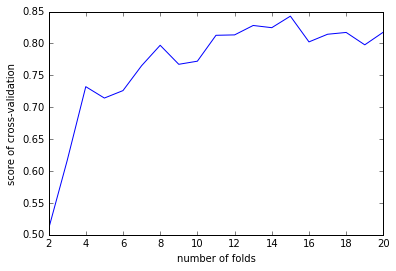

In [16]:
folds = np.arange(2,21,1)
cv_score = []
ratio = []

for i in  np.arange(len(folds)):
    ratio = np.r_[ratio,(1/folds[i])]
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, data_x, data_y, cv=folds[i], scoring='accuracy')
    cv_score = np.r_[cv_score,scores.mean()]

# plot 
plt.plot(folds, cv_score)
plt.xlabel('number of folds')
plt.ylabel('score of cross-validation' )

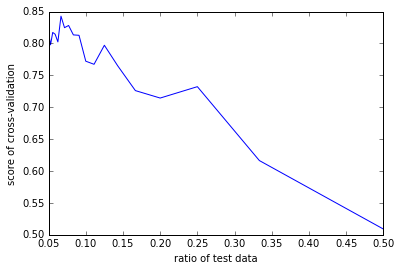

In [17]:
p1 = plt.plot(ratio, cv_score)
plt.xlabel('ratio of test data')
plt.ylabel('score of cross-validation')

Show how different parameters passed to the Classifier affect the overfitting issue. 

### number of estimators

In [18]:
# n_estimators
n = np.arange(1,11,1)
ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)    

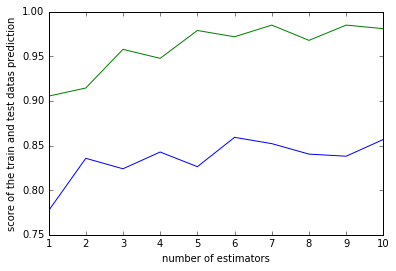

In [20]:
tr_score = []
te_score = []
for i in  np.arange(len(n)):
    clf = RandomForestClassifier(n_estimators = n[i])
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    
# plot 
plt.plot(n, te_score)
plt.plot(n, tr_score)
plt.xlabel('number of estimators')
plt.ylabel('score of the train and test data''s prediction' )

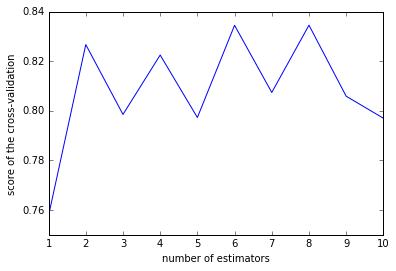

In [22]:
# using cross validation
cv_score = []
folds = 15
for i in  np.arange(len(n)):
    clf = RandomForestClassifier(n_estimators = n[i])
    scores = cross_val_score(clf, data_x, data_y, cv=folds, scoring='accuracy')
    cv_score = np.r_[cv_score, scores.mean()]


    
# plot 
plt.plot(n, cv_score)
plt.xlabel('number of estimators')
plt.ylabel('score of the cross-validation' )

### minimum of samples required to split the data

In [24]:
#min_samples_split
nss = np.arange(0.1,1.,0.1)
n = 6
ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)    


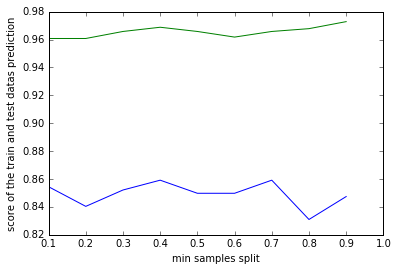

In [25]:
tr_score = []
te_score = []
for i in  np.arange(len(nss)):
    clf = RandomForestClassifier(n_estimators = n, min_samples_split = nss[i])
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    
# plot 
plt.plot(nss, te_score)
plt.plot(nss, tr_score)
plt.xlabel('min samples split')
plt.ylabel('score of the train and test data''s prediction' )

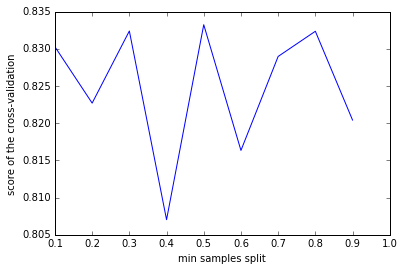

In [26]:
# using cross validation
cv_score = []
folds = 15

for i in  np.arange(len(nss)):
    clf = RandomForestClassifier(n_estimators = n, min_samples_split = nss[i])
    scores = cross_val_score(clf, data_x, data_y, cv=folds, scoring='accuracy')
    cv_score = np.r_[cv_score, scores.mean()]


    
# plot 
plt.plot(nss, cv_score)
plt.xlabel('min samples split')
plt.ylabel('score of the cross-validation' )

### minimum of samples in a leaf

In [27]:
#min_samples_leaf
nsl = np.arange(0.1,1.,0.1)
nss = 0.5
n = 6
ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)    

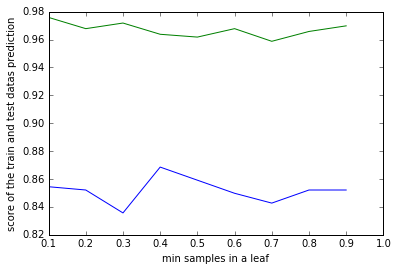

In [29]:
tr_score = []
te_score = []
for i in  np.arange(len(nsl)):
    clf = RandomForestClassifier(n_estimators = n, min_samples_split = nss ,min_samples_leaf = nsl[i])
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    
# plot 
plt.plot(nsl, te_score)
plt.plot(nsl, tr_score)
plt.xlabel('min samples in a leaf')
plt.ylabel('score of the train and test data''s prediction' )

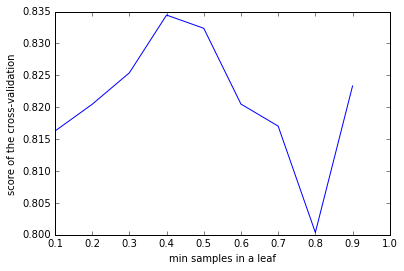

In [32]:
# using cross validation
cv_score = []
folds = 15

for i in  np.arange(len(nsl)):
    clf = RandomForestClassifier(n_estimators = n,min_samples_split = nss,min_samples_leaf = nsl[i])
    scores = cross_val_score(clf, data_x, data_y, cv=folds, scoring='accuracy')
    cv_score = np.r_[cv_score, scores.mean()]


    
# plot 
plt.plot(nsl, cv_score)
plt.xlabel('min samples in a leaf')
plt.ylabel('score of the cross-validation' )

### Feature's importance

Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. 

In [33]:
n = 6
nss = 0.5
nsf = 0.4

clf = RandomForestClassifier(n_estimators = n,min_samples_split = nss,min_samples_leaf = nsl[i])
clf = clf.fit(data_x, data_y)

clf.feature_importances_

array([ 0.06564344,  0.06670871,  0.01523251,  0.04194246,  0.04677733,
        0.06731397,  0.02511092,  0.06123009,  0.11895013,  0.05676476,
        0.14847233,  0.05452089,  0.06384752,  0.05108286,  0.07182144,
        0.04458064])

With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

BONUS: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?